# Проект 7 - Приоритезация гипотез и A/B тесты

## Введение

**Описание проекта**

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

**Описание данных**

Таблица `hypothesis.csv`.

1. `Hypothesis` — краткое описание гипотезы
2. `Reach` — охват пользователей по 10-балльной шкале
3. `Impact` — влияние на пользователей по 10-балльной шкале
4. `Confidence` — уверенность в гипотезе по 10-балльной шкале
5. `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы

Таблица `orders.csv`.

1. `transactionId` — идентификатор заказа
2. `visitorId` — идентификатор пользователя, совершившего заказ
3. `date` — дата, когда был совершён заказ
4. `revenue` — выручка заказа
5. `group` — группа A/B-теста, в которую попал заказ

Таблица `visitors.csv`.

1. `date` — дата
2. `group` — группа A/B-теста
3. `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

## Предобработка данных

Для начала проверим какие данные нам достались. Нас интересуют:

1. Названия колонок.
2. Артефакты в данных.
3. Типы данных.

Пойдем по порядку.

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from datetime import datetime, timedelta
from IPython.display import display
plt.style.use('default')

# Save raw datasets in case we need them
try:
    raw_visitors = pd.read_csv('visitors.csv')
    raw_orders = pd.read_csv('orders.csv')
    raw_hypothesis = pd.read_csv('hypothesis.csv')
except:
    raw_visitors = pd.read_csv('/datasets/visitors.csv')
    raw_orders = pd.read_csv('/datasets/orders.csv')
    raw_hypothesis = pd.read_csv('/datasets/hypothesis.csv')

# Constants, which we will need later
FIG_WIDTH = 10
FIG_HEIGHT = 5


In [69]:
# Let's have a look what is inside
for data_frame in [raw_visitors, raw_orders, raw_hypothesis]:
    display(data_frame.head(3))
    data_frame.info()
    print(50 * '-')


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
--------------------------------------------------


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
--------------------------------------------------


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
--------------------------------------------------


Очень красивые таблицы. Причешем их немного.

In [70]:
# Datasets, which we will clean up
df_visitors, df_orders, df_hypothesis = (
    raw_visitors.copy(), raw_orders.copy(), raw_hypothesis.copy()
)

df_visitors = df_visitors.sort_values(by='date')
df_orders = df_orders.sort_values(by='date')

# Snake case for column names
for data_frame in [df_visitors, df_orders, df_hypothesis]:
    data_frame.columns = data_frame.columns.str.lower()

# Rename a couple of columns
df_orders = (
    df_orders
    .rename(
        columns={
            'transactionid': 'transaction_id',
            'visitorid': 'visitor_id'
        }
    )
)

# Set data types
df_visitors = (
    df_visitors
    .astype({
        'date': 'datetime64[D]',
        'group': 'object',
        'visitors': 'int64'
    })
)

df_orders = (
    df_orders
    .astype({
        'transaction_id': 'int64',
        'visitor_id': 'int64',
        'date': 'datetime64[D]',
        'revenue': 'int64',
        'group': 'object'
    })
)

df_hypothesis = (
    df_hypothesis
    .astype({
        'hypothesis': 'object',
        'reach': 'int64',
        'impact': 'int64',
        'confidence': 'int64',
        'efforts': 'int64',
    })
)


Проверим данные на артефакты.

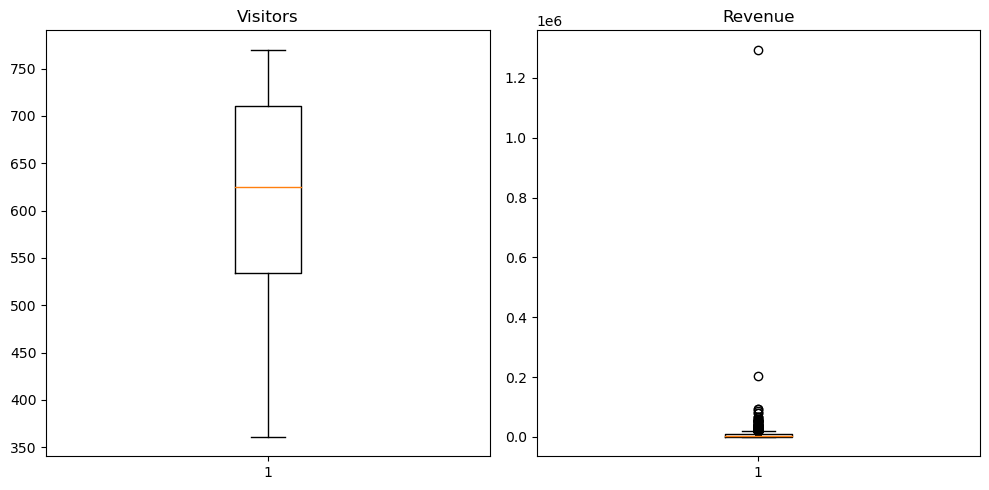

In [71]:
# Boxplots first
def fun_get_boxplots_for_columns(columns: list,
                                 titles: list,
                                 num_rows: int,
                                 num_columns: int):
    """
    This function creates a num_rows x num_columns box subplots for a list of columns out of the dataset.

    Args:
        columns (List): list of columns to plot from a DataFrame.

        titles (List): list of titles for subplots.

        num_rows (int): number of rows in subplots.

        num_columns (int): number of columns in subplots.
    """
    # Create subplots
    fig, axs = plt.subplots(
        num_rows, num_columns,
        figsize=(FIG_WIDTH, FIG_HEIGHT)
        )

    # Popuplate subplots
    for i, ax in enumerate(axs.flat):
        ax.boxplot(columns[i].dropna())
        ax.set_title(titles[i])

    plt.tight_layout()


fun_get_boxplots_for_columns(
    [df_visitors.visitors, df_orders.revenue],
    ['Visitors', 'Revenue'],
    1, 2
)


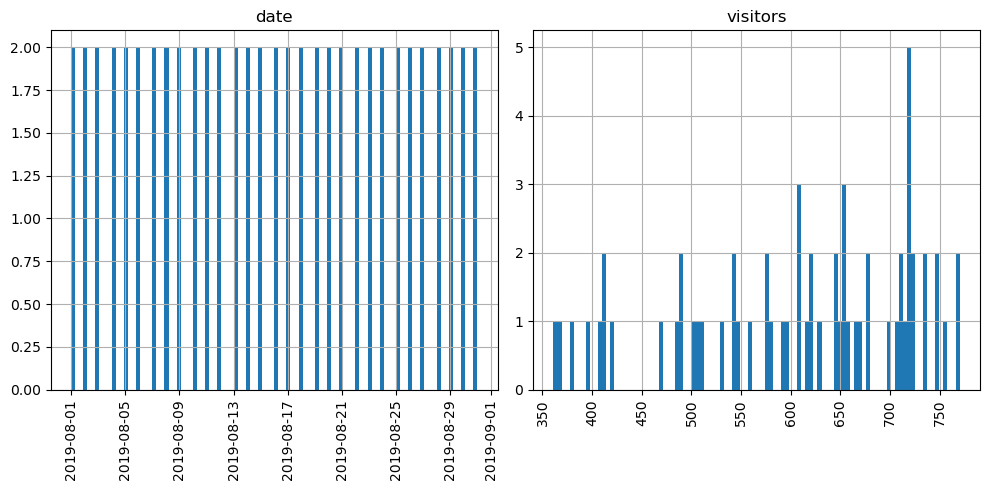

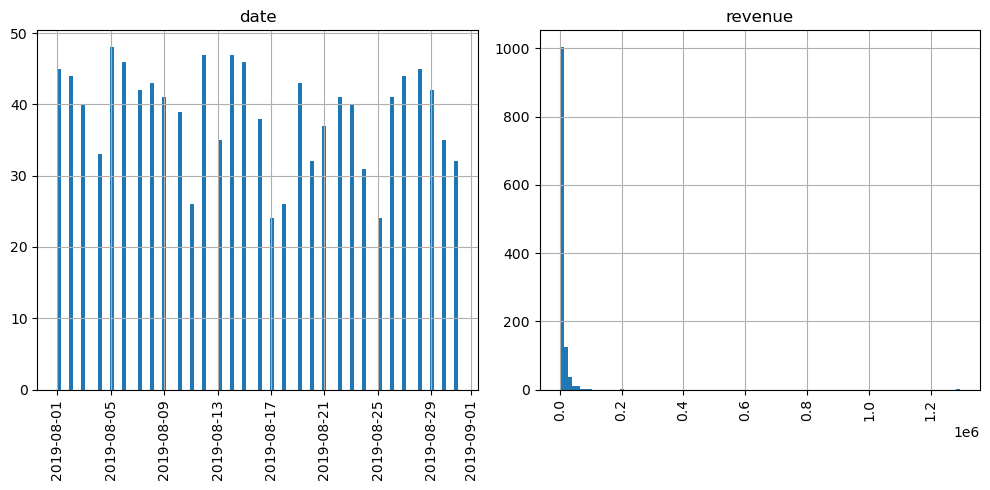

In [72]:
# Histograms
for data_frame in [
    df_visitors[['date', 'visitors']], 
    df_orders[['date', 'revenue']]
    ]:
    
    data_frame.hist(
        bins=100,
        figsize=(FIG_WIDTH, FIG_HEIGHT),
        xrot=90
    )
    
    plt.tight_layout()


У нас явно есть выбросы в данных `revenue`. Дальше по заданию нас просят посчитать перцентили, поэтому мы разберемся с ними позже.

## Приоритизация гипотез

Посмотрим, какие гипотезы у нас есть, какие из них интереснее.

In [73]:
# ICE and RICE prioritization
df_hypothesis['ice'] = df_hypothesis.impact * df_hypothesis.confidence / df_hypothesis.efforts
df_hypothesis['rice'] = df_hypothesis.reach * df_hypothesis.impact * df_hypothesis.confidence / df_hypothesis.efforts
df_hypothesis = df_hypothesis.sort_values(by=['ice', 'rice'], ascending=False)

# Show me the whole dataframe
(df_hypothesis
 .style
 .background_gradient()
 .format({
     'ice': '{:.1f}',
     'rice': '{:.1f}'
 })
)

,hypothesis,reach,impact,confidence,efforts,ice,rice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


Резльутаты получились интересные:

1. По ICE самые привлекательные гипотезе - #8 и #0. Обе находятся высоко в списке, потому что `impact` и `confidence` самые высокие, при `effort` в районе 5.

2. По RICE самые привлекательные гипотезы #7 и #2. Они так высокоо, потому что имеют самый большой `reach` по сравнению с остальными гипотезами. Это же объясняет разницу между ICE и RICE.


## A/B тестирование

Текст здесь

<AxesSubplot:>

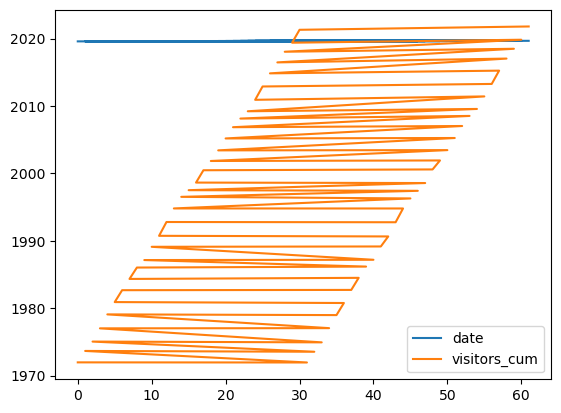

In [77]:
# Get dataframes per group
# df_visitors_a = df_visitors[df_visitors.group == 'A']
# df_visitors_b = df_visitors[df_visitors.group == 'B']
# df_orders_a = df_orders[df_orders.group == 'A']
# df_orders_b = df_orders[df_orders.group == 'B']

df_visitors['visitors_cum'] = (
      df_visitors
      .groupby('group')
      .visitors
      .transform(pd.Series.cumsum)
)

(df_visitors[['date', 'visitors_cum']]
 .plot(
     kind='line',
     
 )
)